# 🔬 Global `SARS-CoV-2` DNA Sequence Analysis
### 🦠 `3631` Sequences of Covid-19 on GenBank

Downloads avaliable from The National Library of Medicine [NCBI Virus](https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&VirusLineage_ss=SARS-CoV-2,+taxid:2697049) resource.
1. Download all `fasta` nulcleotide sequences
2. Download `Current table view` csv for all sequence metadata 

Sequence data also available from the _China National Center for Bioinformation_ [CNCB](https://bigd.big.ac.cn/ncov/release_genome?lang=en#goto)

In [68]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 50
%matplotlib inline

from Bio.Seq import Seq
from Bio import SeqIO, pairwise2
from Bio.pairwise2 import format_alignment

In [145]:
from tqdm.notebook import tqdm

#### 1. View NCBI Metadata

In [2]:
df = pd.read_csv('../data/NCBI_sequences_metadata.csv')
df.head(2)

,Accession,Release_Date,Species,Genus,Family,Length,Sequence_Type,Nuc_Completeness,Genotype,Segment,Authors,Publications,Geo_Location,Host,Isolation_Source,Collection_Date,BioSample,GenBank_Title
0,NC_045512,2020-01-13T00:00:00Z,Severe acute respiratory syndrome-related coro...,Betacoronavirus,Coronaviridae,29903,RefSeq,complete,NaN,NaN,"Baranov,P.V., Henderson,C.M., Anderson,C.B., G...","15680415, 15630477, 10482585",China,Homo sapiens,NaN,2019-12,NaN,Severe acute respiratory syndrome coronavirus ...
1,MT459832,2020-05-13T00:00:00Z,Severe acute respiratory syndrome-related coro...,Betacoronavirus,Coronaviridae,29818,GenBank,complete,NaN,NaN,"Kassela,K., Dovrolis,N., Bampali,M., Gatzidou,...",NaN,Greece: Athens,Homo sapiens,NaN,2020-03-24,NaN,Severe acute respiratory syndrome coronavirus ...


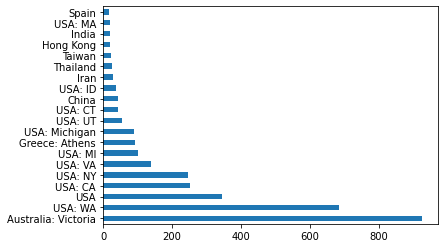

In [16]:
df.Geo_Location.value_counts().head(20).plot(kind='barh')

In [17]:
df.Host.value_counts()

Homo sapiens                3610
Mustela lutreola              13
Canis lupus familiaris         2
Felis catus                    2
Panthera tigris jacksoni       1
Name: Host, dtype: int64

* `Panthera Tigris Jacksoni` is a Malaysian Tiger from the Bronx Zoo in New York  
  
From WCS Newsroom
> On April 5, 2020, we reported that a four-year-old female Malayan tiger had tested positive for COVID-19. We can confirm that the **three other tigers in Tiger Mountain and the three African lions** that exhibited a cough have also **tested positive** for COVID-19.

#### 2. Parse Sequence Records

In [18]:
%%time
data = SeqIO.index("../data/SARS-CoV-2-sequences.fasta", "fasta")

COVID-19 DNA Sequences: 3632
CPU times: user 1.03 s, sys: 750 ms, total: 1.78 s
Wall time: 1.74 s


In [25]:
# Get accession
records = list(data)

print(f'COVID-19 DNA Sequences: {len(data)}\n')
for i, record in enumerate(records[:4]):
    print(f'{i}. {data[record].description}')

COVID-19 DNA Sequences: 3632

0. NC_045512 |Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1| complete genome
1. MT459832 |Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/GRC/34_36284/2020| complete genome
2. MT459833 |Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/GRC/43_35679/2020| complete genome
3. MT459834 |Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/GRC/50_36277/2020| complete genome


#### 3. Create dataset

In [374]:
%%time

def load_dataset(n_samples='full'):
    keep_cols = ['Accession', 'Geo_Location', 'Collection_Date']
    print('loading full sequence dataset')
    df = pd.read_csv('../data/NCBI_sequences_metadata.csv')[keep_cols]
    df['Seq'] = [data[rec].seq for rec in list(data)]
    
    if n_samples != 'full':
        print(f'creating n={n_samples} samples')
        df = pd.concat([df.head(1), df.sample(n_samples-1, random_state=1)])
    
    df['Len'] = df.Seq.apply(lambda x: len(x))
    df['Proteins'] = df.Seq.apply(lambda s: len(s.translate()))
    df['Collection_Date'] = pd.to_datetime(df.Collection_Date)
    df.at[0, 'Collection_Date'] = pd.to_datetime('2019-12-29')
    df['Days_Since_Origin'] = (df['Collection_Date'] - pd.to_datetime('2019-12-29')).dt.days
    return df.sort_values('Collection_Date', ascending=True).reset_index(drop=True)

df = load_dataset(n_samples='full')
print('Dataframe:', df.shape)
df.head()

loading full sequence dataset
Dataframe: (3632, 7)
CPU times: user 30.1 s, sys: 93.8 ms, total: 30.2 s
Wall time: 30.4 s


,Accession,Geo_Location,Collection_Date,Seq,Len,Proteins,Days_Since_Origin
0,MN908947,China,2019-12-01,"(A, T, T, A, A, A, G, G, T, T, T, A, T, A, C, ...",29903,9967,-28.0
1,MT019529,"China: Hubei, Wuhan",2019-12-23,"(A, T, T, A, A, A, G, G, T, T, T, A, T, A, C, ...",29899,9966,-6.0
2,LR757998,China:Wuhan,2019-12-26,"(A, A, C, A, A, A, C, C, A, A, C, C, A, A, C, ...",29866,9955,-3.0
3,LR757995,China:Wuhan,2019-12-26,"(T, T, T, C, C, C, A, G, G, T, A, A, C, A, A, ...",29872,9957,-3.0
4,NC_045512,China,2019-12-29,"(A, T, T, A, A, A, G, G, T, T, T, A, T, A, C, ...",29903,9967,0.0


In [ ]:
# TODO: filter out sequences that are way too small

#### Sequence Alignment
* `Global alignment` finds the best concordance/agreement between all characters in two sequences
* `Local Alignment` finds just the subsequences that align the best

In [363]:
def pairwise_alignment(s1, s2, n, verbose=True):
    if n == 'full': n = min(len(s1), len(s2))
    alignment = pairwise2.align.globalxx(s1[0:n], s2[0:n], one_alignment_only=True, score_only=True)
    if verbose:
        print(f'Pairwise alignment: {alignment:.0f}/{n} ({(alignment/n)*100:0.2f}%)')
        print(f'Number of sequence differences: {int(n-alignment)}')
    return int(n-alignment)
    
# Sequence differences in samples:
pairwise_alignment(df.Seq[1], df.Seq[2], n=1000)

Pairwise alignment: 347/1000 (34.70%)
Number of sequence differences: 653


653

In [375]:
# Run sequence alignment against origin sample (slow)
res = []
for i in tqdm(range(len(df))):
    res.append(pairwise_alignment(df.Seq[0], df.Seq[i], n='full', verbose=False))

df['Sequence_diff'] = pd.Series(res)
df.head()

,Accession,Geo_Location,Collection_Date,Seq,Len,Proteins,Days_Since_Origin,Sequence_diff
0,MN908947,China,2019-12-01,"(A, T, T, A, A, A, G, G, T, T, T, A, T, A, C, ...",29903,9967,-28.0,0
1,MT019529,"China: Hubei, Wuhan",2019-12-23,"(A, T, T, A, A, A, G, G, T, T, T, A, T, A, C, ...",29899,9966,-6.0,3
2,LR757998,China:Wuhan,2019-12-26,"(A, A, C, A, A, A, C, C, A, A, C, C, A, A, C, ...",29866,9955,-3.0,27
3,LR757995,China:Wuhan,2019-12-26,"(T, T, T, C, C, C, A, G, G, T, A, A, C, A, A, ...",29872,9957,-3.0,17
4,NC_045512,China,2019-12-29,"(A, T, T, A, A, A, G, G, T, T, T, A, T, A, C, ...",29903,9967,0.0,0


In [376]:
df['Sequence_diff'] = pd.Series(res)

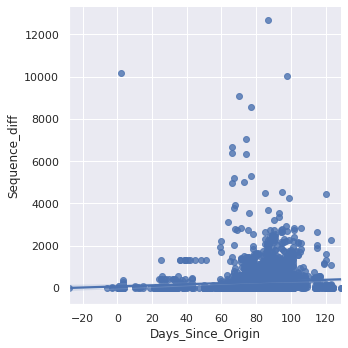

In [377]:
#ax = sns.scatterplot(data=df[['Collection_Date', 'Sequence_diff']].sort_values('Collection_Date', ascending=True))

sns.lmplot(x="Days_Since_Origin", y="Sequence_diff", data=df)

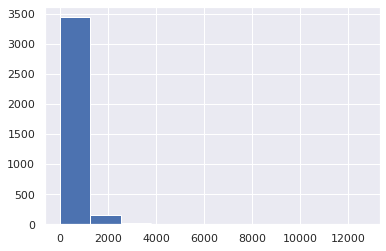

In [399]:
df.Sequence_diff.hist()

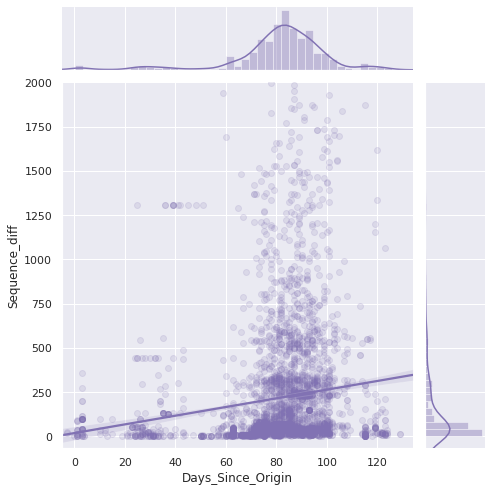

In [410]:
sns.set(style="darkgrid")

seq_lim = 2000
g = sns.jointplot(x="Days_Since_Origin", y="Sequence_diff", data=df[df.Sequence_diff < seq_lim],
                  kind="reg", truncate=False,
                  xlim=(-5, df.Days_Since_Origin.max()+5), 
                  ylim=(-seq_lim/30, seq_lim),
                  color="m", height=7, scatter_kws={'alpha': 0.15})

> The other bit of information to come out of this study is an indication of where changes in the virus' proteins are tolerated. **This inability to tolerate changes in an area of the genome tends to be an indication that the protein encoded by that part of the genome has an essential function.** The researchers identified a number of these, one of which is the part of the spike protein that came from the pangolin virus.    

>Of all 6,400 of the SARS-CoV-2 genomes isolated during the pandemic, **only eight from a single cluster of cases had any changes in this region.** So, it's looking likely that the pangolin sequence is essential for the virus' ability to target humans.

John Timmer, 6/2/2020. Arstechnica. [SARS-CoV-2 looks like a hybrid of viruses from two different species](https://arstechnica.com/science/2020/06/sars-cov-2-looks-like-a-hybrid-of-viruses-from-two-different-species/)

Science Advances, 2019. [DOI: 10.1126/sciadv.abb9153](https://advances.sciencemag.org/content/early/2020/05/28/sciadv.abb9153)


> A key stretch of the spike protein, the one that determines which proteins on human cells it   
interacts with, **came from a pangolin version of the virus** through recombination.

* TODO: Find the area that has very few mutations, find the spike protein

In [113]:
pairwise_alignment(df.Seq[0], df.Seq[1], n='full')

Pairwise alignment: 29780/29818 (99.9%)


In [108]:
pairwise_alignment(df.Seq[2], df.Seq[11], n='full')

Pairwise alignment: 29801/29818 (99.9%)


In [109]:
pairwise_alignment(df.Seq[3], df.Seq[33], n='full')

Pairwise alignment: 29808/29818 (100.0%)


In [110]:
pairwise_alignment(df.Seq[44], df.Seq[88], n='full')

Pairwise alignment: 29643/29818 (99.4%)


In [111]:
pairwise_alignment(df.Seq[0], df.Seq[99], n='full')

Pairwise alignment: 29871/29890 (99.9%)


In [9]:
# Noteworthy records
patient_zero = 'NC_045512'
recent_cali = 'MT460092'
bronx_tiger = 'MT365033'

samples = [patient_zero, recent_cali, bronx_tiger]

data[patient_zero].seq

Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...AAA', SingleLetterAlphabet())

In [10]:
data[bronx_tiger].seq

Seq('GGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCT...AAA', SingleLetterAlphabet())

In [11]:
df[df.Accession.isin(samples)]

,Accession,Release_Date,Species,Genus,Family,Length,Sequence_Type,Nuc_Completeness,Genotype,Segment,Authors,Publications,Geo_Location,Host,Isolation_Source,Collection_Date,BioSample,GenBank_Title
0,NC_045512,2020-01-13T00:00:00Z,Severe acute respiratory syndrome-related coro...,Betacoronavirus,Coronaviridae,29903,RefSeq,complete,NaN,NaN,"Baranov,P.V., Henderson,C.M., Anderson,C.B., G...","15680415, 15630477, 10482585",China,Homo sapiens,NaN,2019-12,NaN,Severe acute respiratory syndrome coronavirus ...
106,MT460092,2020-05-13T00:00:00Z,Severe acute respiratory syndrome-related coro...,Betacoronavirus,Coronaviridae,29857,GenBank,complete,NaN,NaN,"CZB Cliahub Consortium,C.C.C.",NaN,USA: CA,Homo sapiens,NaN,2020-05-01,NaN,Severe acute respiratory syndrome coronavirus ...
2125,MT365033,2020-04-24T00:00:00Z,Severe acute respiratory syndrome-related coro...,Betacoronavirus,Coronaviridae,29897,GenBank,complete,NaN,NaN,"Mitchell,P., Anderson,R.R., Chilson,B., Venugo...",NaN,USA: New York,Panthera tigris jacksoni,"oronasopharynx, oronasopharynx",2020-04-02,NaN,Severe acute respiratory syndrome coronavirus ...


In [12]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from collections import Counter

In [13]:
# DNA to mRNA to Polypeptide (protein)
data[recent_cali].seq.transcribe().translate()

Seq('SQVTNQPTFDLL*ICSLNEL*NLCGCHSAACLVHSRSIINN*LLSLTGHE*LVY...NDK', HasStopCodon(ExtendedIUPACProtein(), '*'))

In [14]:
for s in samples:
    print(s)
    print(data[s].seq.transcribe().translate()[:100])

NC_045512
IKGLYLPR*QTNQLSISCRSVL*TNFKICVAVTRLHA*CTHAV*LITNYCR*QDTSNSSIFCRLLTVSSVLQPIISTSRFRPGVTER*DGEPCPWFQREN
MT460092
SQVTNQPTFDLL*ICSLNEL*NLCGCHSAACLVHSRSIINN*LLSLTGHE*LVYLLQAAYGFVRVAADHQHI*VSSGCDRKVRWRALSLVSTRKHTSNSV
MT365033
GLYLPR*QTNQLSISCRSVL*TNFKICVAVTRLHA*CTHAV*LITNYCR*QDTSNSSIFCRLLTVSSVLQPIISTSRFCPGVTER*DGEPCPWFQRENTR


In [34]:
data[bronx_tiger].seq.transcribe().translate()

Seq('GLYLPR*QTNQLSISCRSVL*TNFKICVAVTRLHA*CTHAV*LITNYCR*QDTS...KKK', HasStopCodon(ExtendedIUPACProtein(), '*'))

### Dot Plots of Opening Sequences

In [114]:
def delta(x,y):
    return 0 if x == y else 1

def M(seq1,seq2,i,j,k):
    return sum(delta(x,y) for x,y in zip(seq1[i:i+k],seq2[j:j+k]))

def makeMatrix(seq1,seq2,k):
    n = len(seq1)
    m = len(seq2)
    return [[M(seq1,seq2,i,j,k) for j in range(m-k+1)] for i in range(n-k+1)]

def plotMatrix(M,t, seq1, seq2, nonblank = chr(0x25A0), blank = ' '):
    print(' |' + seq2)
    print('-'*(2 + len(seq2)))
    for label,row in zip(seq1,M):
        line = ''.join(nonblank if s < t else blank for s in row)
        print(label + '|' + line)

def dotplot(seq1,seq2,k = 1,t = 1):
    M = makeMatrix(seq1,seq2,k)
    plotMatrix(M, t, seq1,seq2) #experiment with character choice

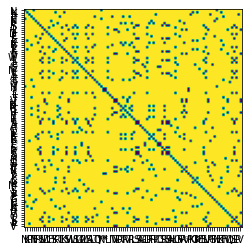

In [119]:
# Plotting function to illustrate deeper matches

def dotplotx(seq1, seq2, n):
    seq1=seq1[0:n]
    seq2=seq2[0:n]
    plt.imshow(np.array(makeMatrix(seq1,seq2,1)))
    # on x-axis list all sequences of seq 2
    xt=plt.xticks(np.arange(len(list(seq2))),list(seq2))
    # on y-axis list all sequences of seq 1
    yt=plt.yticks(np.arange(len(list(seq1))),list(seq1))
    plt.show()
    
dotplotx(df.Seq[1].transcribe().translate(),
         df.Seq[3].transcribe().translate(), n=100)